In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [8]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error, roc_curve, auc
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, MultiHeadAttention, Add, GlobalAveragePooling1D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.backend import clear_session
from scipy.signal import savgol_filter


In [4]:
dataset_path = "/content/drive/My Drive/mhealth+dataset (1)/MHEALTHDATASET"

columns = [
    'acc_chest_x', 'acc_chest_y', 'acc_chest_z',
    'ecg_chest_1', 'ecg_chest_2',
    'acc_ankle_x', 'acc_ankle_y', 'acc_ankle_z',
    'gyro_ankle_x', 'gyro_ankle_y', 'gyro_ankle_z',
    'magnet_ankle_x', 'magnet_ankle_y', 'magnet_ankle_z',
    'acc_arm_x', 'acc_arm_y', 'acc_arm_z',
    'gyro_arm_x', 'gyro_arm_y', 'gyro_arm_z',
    'magnet_arm_x', 'magnet_arm_y', 'magnet_arm_z',
    'activity'
]

activity_labels = {
    1: 'Standing still', 2: 'Sitting and relaxing', 3: 'Lying down',
    4: 'Walking', 5: 'Climbing stairs', 6: 'Waist bends forward',
    7: 'Frontal elevation of arms', 8: 'Knees bending (crouching)',
    9: 'Cycling', 10: 'Jogging', 11: 'Running', 12: 'Jump front & back'
}


In [5]:
def load_mhealth_data(path):
    all_data = []
    for file in sorted(os.listdir(path)):
        if file.endswith('.log'):
            df = pd.read_csv(os.path.join(path, file), delim_whitespace=True, header=None)
            df.columns = columns
            all_data.append(df)
    return pd.concat(all_data, ignore_index=True)

df = load_mhealth_data(dataset_path)
scaler = StandardScaler()
df[columns[:-1]] = scaler.fit_transform(df[columns[:-1]])


In [6]:
def segment_data(data, window_size=80, step=40):
    X, y = [], []
    for start in range(0, len(data) - window_size, step):
        end = start + window_size
        segment = data.iloc[start:end]
        if len(segment['activity'].unique()) == 1:
            X.append(segment.drop('activity', axis=1).values)
            y.append(segment['activity'].iloc[0])
    return np.array(X), np.array(y)

X, y = segment_data(df)
y_encoded = to_categorical(y - 1)
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)


In [9]:
from tensorflow.keras.layers import GRU

clear_session()

input_shape = X.shape[1:]
inputs = Input(shape=input_shape)

x = GRU(64, return_sequences=True)(inputs)
x = Dropout(0.3)(x)
x = GRU(32)(x)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(y_train.shape[1], activation='softmax')(x)

model = Model(inputs, outputs)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
]

start = time.time()
history = model.fit(X_train, y_train,
                    epochs=20,
                    batch_size=128,
                    validation_data=(X_test, y_test),
                    callbacks=callbacks,
                    verbose=1)
end = time.time()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 80, 23)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 80, 64)         │        17,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 80, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 12)             │           780 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,388 (114.80 KB)

 Trainable params: 29,388 (114.80 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 28s 130ms/step - accuracy: 0.5550 - loss: 1.6427 - val_accuracy: 0.7697 - val_loss: 0.7247 - learning_rate: 0.0010
Epoch 2/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 41s 133ms/step - accuracy: 0.7688 - loss: 0.7245 - val_accuracy: 0.8149 - val_loss: 0.4313 - learning_rate: 0.0010
Epoch 3/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 25s 132ms/step - accuracy: 0.8053 - loss: 0.4705 - val_accuracy: 0.8557 - val_loss: 0.3330 - learning_rate: 0.0010
Epoch 4/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 43s 141ms/step - accuracy: 0.8398 - loss: 0.3618 - val_accuracy: 0.8744 - val_loss: 0.2867 - learning_rate: 0.0010
Epoch 5/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 38s 127ms/step - accuracy: 0.8561 - loss: 0.3141 - val_accuracy: 0.8796 - val_loss: 0.2584 - learning_rate: 0.0010
Epoch 6/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 23s 124ms/step - accuracy: 0.8664 - loss: 0.2912 - val_accuracy: 0.8871 - val_loss: 0.2496 - learning_rate: 0.0010
Epoch 7/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 23s 125ms/step - accuracy: 0.8

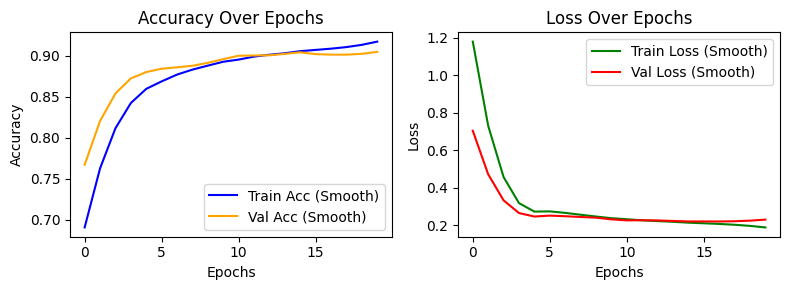

In [16]:
from scipy.signal import savgol_filter

train_acc = savgol_filter(history.history['accuracy'], window_length=9, polyorder=3)
val_acc   = savgol_filter(history.history['val_accuracy'], window_length=9, polyorder=3)
train_loss = savgol_filter(history.history['loss'], window_length=9, polyorder=3)
val_loss   = savgol_filter(history.history['val_loss'], window_length=9, polyorder=3)

plt.figure(figsize=(8, 3))

plt.subplot(1, 2, 1)
plt.plot(train_acc, label="Train Acc (Smooth)", color='blue')
plt.plot(val_acc, label="Val Acc (Smooth)", color='orange')
plt.title("Accuracy Over Epochs")
plt.xlabel("Epochs"); plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_loss, label="Train Loss (Smooth)", color='green')
plt.plot(val_loss, label="Val Loss (Smooth)", color='red')
plt.title("Loss Over Epochs")
plt.xlabel("Epochs"); plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()


187/187 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step


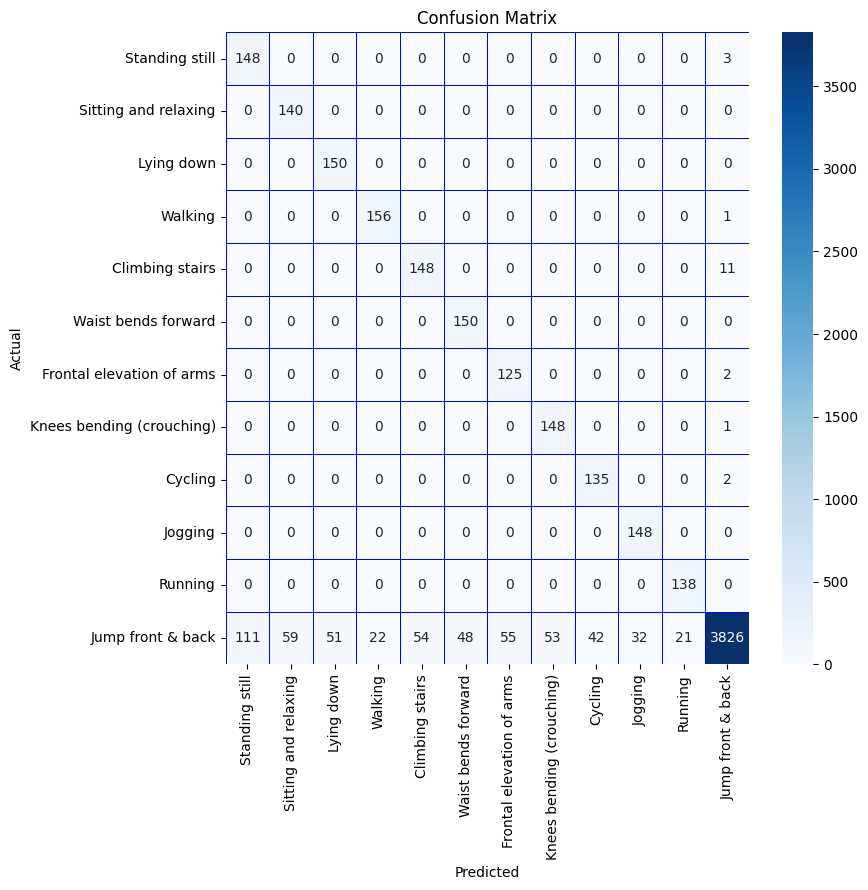

📊 Classification Report:
                           precision    recall  f1-score   support

           Standing still       0.57      0.98      0.72       151
     Sitting and relaxing       0.70      1.00      0.83       140
               Lying down       0.75      1.00      0.85       150
                  Walking       0.88      0.99      0.93       157
          Climbing stairs       0.73      0.93      0.82       159
      Waist bends forward       0.76      1.00      0.86       150
Frontal elevation of arms       0.69      0.98      0.81       127
Knees bending (crouching)       0.74      0.99      0.85       149
                  Cycling       0.76      0.99      0.86       137
                  Jogging       0.82      1.00      0.90       148
                  Running       0.87      1.00      0.93       138
        Jump front & back       0.99      0.87      0.93      4374

                 accuracy                           0.91      5980
                macro avg       0.7

In [13]:
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true_labels, y_pred_labels)
plt.figure(figsize=(9, 9))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=activity_labels.values(),
            yticklabels=activity_labels.values(),
            linewidths=0.5, linecolor='blue')
plt.xlabel("Predicted"); plt.ylabel("Actual"); plt.title("Confusion Matrix")
plt.tight_layout(); plt.show()

print("📊 Classification Report:")
report = classification_report(y_true_labels, y_pred_labels, target_names=activity_labels.values(), output_dict=True)
print(classification_report(y_true_labels, y_pred_labels, target_names=activity_labels.values()))

accuracy = np.mean(y_pred_labels == y_true_labels)
mse = mean_squared_error(y_true_labels, y_pred_labels)
sensitivity = np.mean([report[label]['recall'] for label in activity_labels.values()])

specificity_list = []
for i in range(len(activity_labels)):
    tn = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
    fp_fn = cm.sum() - cm[:, i].sum()
    specificity_list.append(tn / fp_fn if fp_fn != 0 else 0)
specificity = np.mean(specificity_list)

print(f"\n✅ Final Evaluation:")
print(f"✔️ Accuracy     : {accuracy * 100:.2f}%")
print(f"✔️ Sensitivity  : {sensitivity:.4f}")
print(f"✔️ Specificity  : {specificity:.4f}")
print(f"✔️ MSE          : {mse:.4f}")
print(f"✔️ Training Time: {end - start:.2f} sec")


In [14]:
train_loss, train_acc = model.evaluate(X_train, y_train, verbose=0)
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
val_loss = history.history['val_loss'][-1]
val_acc = history.history['val_accuracy'][-1]

print(f"\n🎯 Train Accuracy: {train_acc*100:.2f}% | Loss: {train_loss:.4f}")
print(f"📊 Val Accuracy: {val_acc*100:.2f}%   | Loss: {val_loss:.4f}")
print(f"✅ Test Accuracy: {test_acc*100:.2f}% | Loss: {test_loss:.4f}")



🎯 Train Accuracy: 91.40% | Loss: 0.1904
📊 Val Accuracy: 90.95%   | Loss: 0.2257
✅ Test Accuracy: 90.50% | Loss: 0.2134


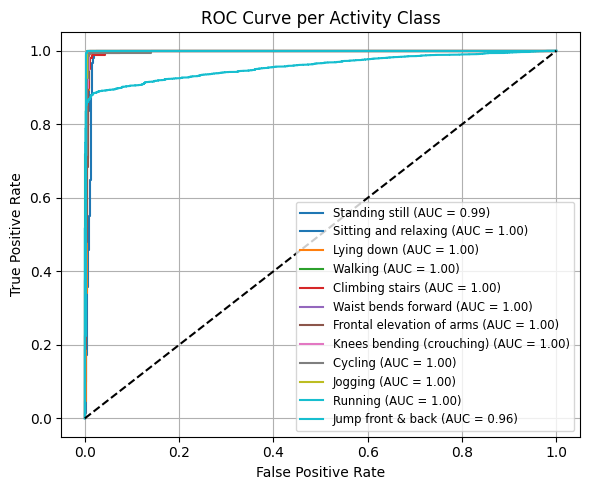

In [15]:
fpr = dict(); tpr = dict(); roc_auc = dict()
n_classes = y_test.shape[1]
colors = plt.cm.get_cmap('tab10', n_classes).colors

plt.figure(figsize=(6, 5))
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i],
             label=f"{activity_labels[i+1]} (AUC = {roc_auc[i]:.2f})",
             color=colors[i % len(colors)])

plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve per Activity Class")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right", fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()
